To downlaod MNIST database scikit learn has a function

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

/Users/keshav/ml/my_env/lib/python3.9/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets which are loaded by scikit learn have kind of similar structure. DESCR -- describing the dataset, data-one row per instance and one column per feature. target--array with labels


In [2]:
X, y = mnist["data"],mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

So totally 700000 images with 784 features each. That's a lot of features. Each image is 28 * 28 pixels and each feature is representing one pixel's intensity from 0 to 255. To visualize grab one instance and convert it to 28 * 28 array and display it by imshow() function.

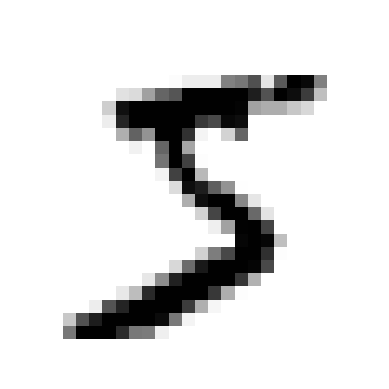

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

This label is a string so let's cast it to integer because most ML algo. requires integers to work with.

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
y[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

Always put aside test set before looking at the data. But MNIST dataset is already shuffled. The last 10000 examples are for test set.

In [9]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

Shuffling the dataset is good. Some ML algo wouldn't perform best if we don't shuffle

## Training a Binary classifier

Simplified Problem -- Number 5 or not. 5 detector. first change the data. then train a model on that data and check to see if it performs well or not.

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
y_train_5[:5]

array([ True, False, False, False, False])

SGD -- Stochastic Gradient Classifier -- Handles large dataset efficiently -- Deals with one training Instance at a time

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

In classifier it is always hard to evaluate and there are many performance measures available.

In [14]:
# To evaluate your model you can use cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

above 95% accuracy that's a good model, now let's look at a dumb one

In [15]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
#for accuracy of this model

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy...... This is because only 10% images are 5s, so if you always guess that image is not 5 then you will right 90% of the time, This shows that accuarcy is not preferred as performance measure for classifier,

### Confusion Matrix

better way to evalaute performance

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,cv=3)

This cross_val_predict will perform K-fold cross validation and it will return prediction made on each test fold. This means you get a clean prediction for each instance in the training set. (clean meaning that prediction is made by a model that never saw data during training. 

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Row - actual, Col - Predicted.. 53892 - TN, 687 - FP, 1891 - FN, 3530 - TP
Perfect classifier would have only True Positives and True Negatives.

accuarcy of the positive prediction which is called precision == TP/TP+FP. Precision is used along with recall also called sensitivity or true positive rate. Ratio of positive instances that are correctly detected by the classifier. Recall = TP/TP+FN 

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

When it claims an image represents 5 it is correct only 83% of the time. Moreover, It only detects 65% of the 5s. 
We can use F1 Score here. You can use that to compare classifiers. F1 score measures harmonic mean of precision and recall. And F1 score also is not sensitive to low value Means if precision and recall both are high then and then we can get high F1 Score.

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

There is a trade off between precision and recall. SGD classifier computes decision for ecah instance and if that score is greater than some threshold then it counts it as positive and vice versa for negative. In scikit learn we do not have access to threshold but we can access decision score by decision_function()

In [22]:
y_scores = sgd_clf.decision_function([some_digit])

In [23]:
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores> threshold)

In [25]:
y_some_digit_pred

array([ True])

In [26]:
# Let's raise the threshold.

threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

This Confirms that raising the threshold decreases the recall. The image is actually 5 and it predicts 5 when thershold was 0 but after increasing the threshold it misses. 

## How to decide which threshold to use?

In [27]:
# use this function to get the scores pf all instances in training set
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5,cv=3,method = 'decision_function')

In [28]:
#With this score you can use precision_recall_curve() to compute precision and recall for all possible thresholds.
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [29]:
def plot_precision_recall_vs_threshold(precisions,recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label='Precision')
    plt.plot(thresholds, recalls[:-1],"g-",label="Recall")
    plt.legend()
    

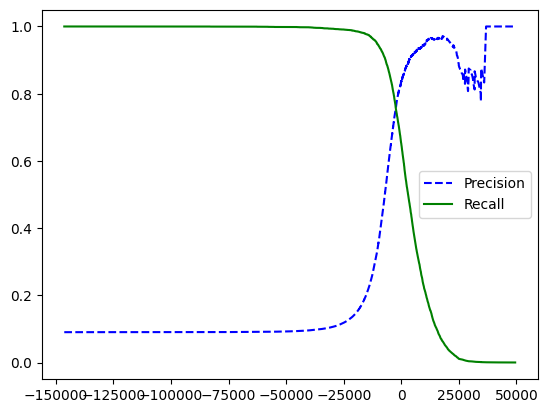

In [30]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

Another way -- Plot precision and recall directly against each other. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


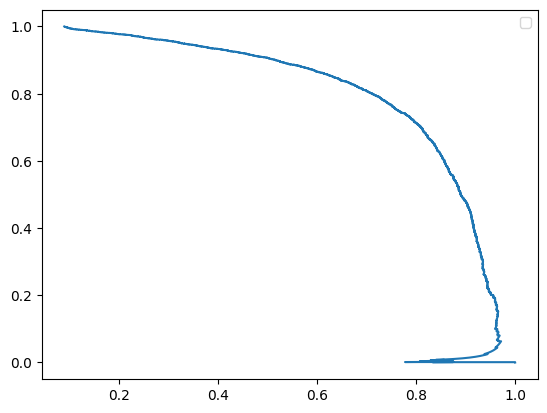

In [31]:
plt.plot(precisions,recalls)
plt.legend()
plt.show()

If you decide 90% precision then you look up the first plot and find lowest threshold that gives 90% precision. (np.argmax can help with this). It will give you first index of the maximum value but in this case first True Value.

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [33]:
threshold_90_precision

3370.0194991439594

In [34]:
#To make predictions 
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

ROC is another common tool used with binary classifiers. Plots TPR against FPR. 

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

In [38]:
fpr[:5]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.83220653e-05,
       1.83220653e-05])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


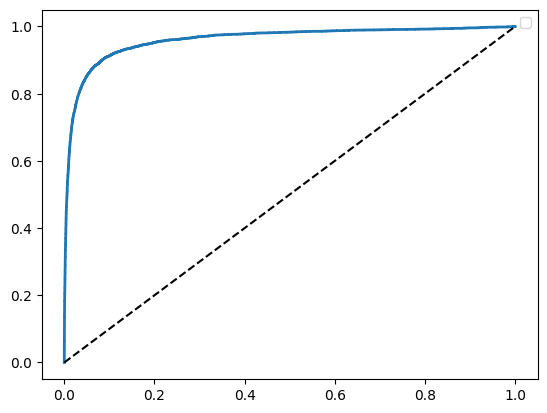

In [39]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.legend()
    
plot_roc_curve(fpr,tpr)
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

Now we train RandomForestClassifier to compare how does this work. But it doens't have decision_function() it has predict_proba() which return probability of given instance belonging to some class.

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5,cv=3,method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

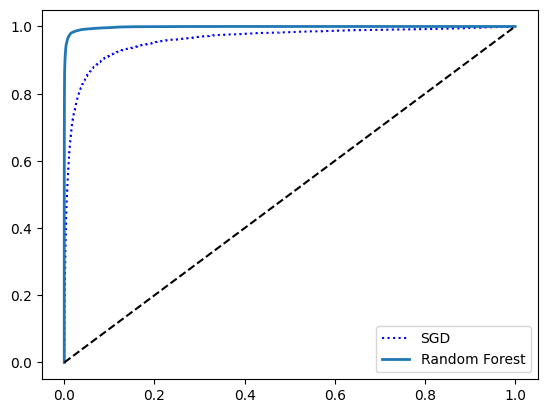

In [43]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [44]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [46]:
# Remember that some algo. are not capable of handling multiple class natively. (Logisitic, SVC)
# OVR vs OVO

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train) # not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood it used OVO strategy. It trained 45 classifiers (10*9 = 90 -> 90/2 = 45). got their decision socre and selected the class that won most duels.
If you call its decision_function it will return 10 scores per ecah instance

In [47]:
some_digit_score = svm_clf.decision_function([some_digit])

In [48]:
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
np.argmax(some_digit_score)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

In [53]:
# You can force OVR or OVO on classifier by using OneVsRestClassifier class or OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC())

In [54]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
len(ovr_clf.estimators_)

10

In [57]:
# Training an SGDClassifier is just as easy.
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [58]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

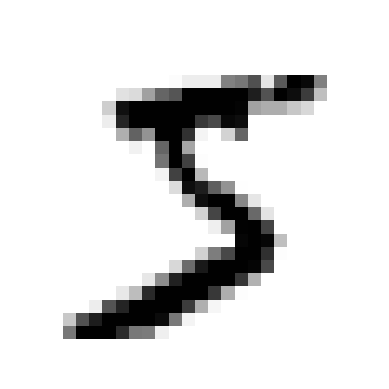

In [61]:
plt.imshow(some_digit.reshape(28,28),cmap='binary')
plt.axis('off')
plt.show()

In [62]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [65]:
# let's look at the concusion matrix
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)

In [66]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

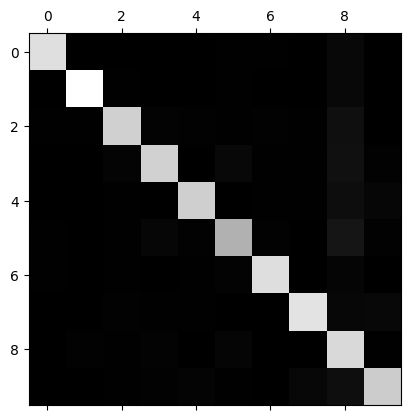

In [67]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

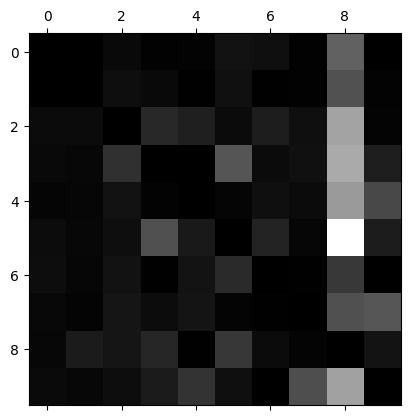

In [70]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [72]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [73]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [74]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605